# Notebook to generate PSTH plots.

This notebook requires the following cached data:
- Processed behavior data for the triangle task, saved in
  `../../../cache/behavior/triangle.csv`. This can be downloaded from the OSF
  repo or can be generated by running the script
  `../../../behavior_processing/run_cache_data.py`.
- Spike trains saved in
  `../../../cache/phys_processing/spikes_to_trials/spikes_per_trial`. This can be
  downloaded from the OSF repo or generated by running the script
  `../../../phys_processing/spikes_to_trials/run_spikes_per_trial.py.`

This notebook generates PSTH plots for 4 neurons and saves them to the directory
`./plots/`.

In [1]:
"""Imports."""

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [ ]:
"""Constants."""

SPIKE_COUNTS_DATA_DIR = Path("../../../cache/phys_processing/spikes_to_trials/spikes_per_trial")
WRITE_DIR = Path("./plots")
BEHAVIOR_CACHE_PATH_TRIANGLE = Path("../../../cache/behavior_processing/triangle.csv")
LEAD_IN_SECONDS = 0.2
BIN_SIZE_SECONDS = 0.01
STIM_TIME_WINDOW = (0, 2500)
PALETTE = {
    (0,): (1, 0, 0),
    (1,): (0, 1, 0),
    (2,): (0, 0, 1),
    (0, 1): (0.7, 0.7, 0),
    (0, 2): (0.7, 0, 0.7),
    (1, 2): (0, 0.7, 0.7),
    (0, 1, 2): (0.5, 0.5, 0.5),
}

# Make sure the write directory exists
WRITE_DIR.mkdir(exist_ok=True, parents=True)

# Load triangle behavior data
triangle_behavior = pd.read_csv(BEHAVIOR_CACHE_PATH_TRIANGLE)

In [3]:
"""Functions for plotting PSTHs."""

def _smooth(spike_count, half_window_size_ms=100):
    """Smooth spike count using a triangular kernel."""
    half_window_bins = int(
        half_window_size_ms / (1000 * BIN_SIZE_SECONDS)
    )
    linspace = np.linspace(0, 1, 1 + half_window_bins)[1:]
    kernel = np.concatenate([linspace[:-1], linspace[::-1]])
    kernel /= kernel.sum()
    conv_spike_count = np.convolve(spike_count, kernel, mode="same")
    conv_ones = np.convolve(np.ones_like(spike_count), kernel, mode="same")
    smooth_spike_count = conv_spike_count / conv_ones
    return smooth_spike_count

def _plot_psth(spike_counts, trials, session_behavior, n_boot=100):
    """Generate PSTH plot for a unit."""
    # Sanity check spike counts and trials have the same length
    if len(spike_counts) != len(trials):
        raise ValueError(
            f"Length of spike_counts ({len(spike_counts)}) must match length "
            f"of trials ({len(trials)})"
        )

    # Create dataframe with spike counts
    df_dict = {
        "time": [],
        "num_objects": [],
        "locations": [],
        "target_location": [],
        "firing_rate": [],
    }
    delay_times = []
    cue_times = []
    response_times = []
    for trial_num, spike_count in zip(trials, spike_counts):
        trial = session_behavior.loc[
            session_behavior["trial_num"] == trial_num
        ]
        if not trial.on_triangle.values[0]:
            continue
        num_objects = trial["num_objects"].values[0]

        # Get delay, cue, and response times
        stim_time = trial.time_stimulus_onset.values[0]
        delay_times.append(trial.time_delay_onset.values[0] - stim_time)
        cue_times.append(trial.time_cue_onset.values[0] - stim_time)
        response_times.append(trial.time_response_onset.values[0] - stim_time)

        # Get target location
        target_ind = trial["target_object_index"].values[0]
        target_location = int(trial[f"object_{target_ind}_location"].values[0])

        # Get object locations
        obj_locations = tuple(
            sorted(
                [
                    int(trial[f"object_{i}_location"].values[0])
                    for i in range(num_objects)
                ]
            )
        )

        # Smooth spike_count
        spike_count = _smooth(spike_count)

        # Update df_dict
        time = 1000 * BIN_SIZE_SECONDS * np.arange(len(spike_count))
        df_dict["time"].extend(time - 1000 * LEAD_IN_SECONDS)
        df_dict["num_objects"].extend([num_objects] * len(time))
        df_dict["locations"].extend([obj_locations] * len(time))
        df_dict["target_location"].extend([target_location] * len(time))
        bins_per_second = 1 / BIN_SIZE_SECONDS
        df_dict["firing_rate"].extend(spike_count * bins_per_second)

    df = pd.DataFrame(df_dict)

    # Get mean delay, cue, and response times
    mean_delay_time = 1000 * np.mean(delay_times)
    mean_cue_time = 1000 * np.mean(cue_times)
    mean_response_time = 1000 * np.mean(response_times)
    mean_phase_times = [mean_delay_time, mean_cue_time, mean_response_time]

    fig, axes = plt.subplots(2, 1, figsize=(2.6, 3.05), sharex=True, sharey=True, dpi=300)
    ymax = 0
    for num_objects, ax in zip([1, 2], axes):
        if num_objects is None:
            tmp_df = df
        else:
            tmp_df = df.loc[df["num_objects"] == num_objects]
        df_stim = tmp_df.loc[
            (tmp_df["time"] >= STIM_TIME_WINDOW[0])
            & (tmp_df["time"] < STIM_TIME_WINDOW[1])
        ]

        # Plot full trial
        plot = sns.lineplot(
            ax=ax,
            data=df_stim,
            x="time",
            y="firing_rate",
            hue="locations",
            palette=PALETTE,
            legend=False,
            n_boot=n_boot,
        )
        ymax = max(ymax, plot.get_ylim()[1])

    for ax in axes:
        sns.despine(ax=ax)
        ax.vlines(
            x=mean_phase_times,
            ymin=0,
            ymax=ymax,
            colors="k",
            linestyles="dashed",
            zorder=-1,
        )
        ax.set_xlim(0, 2500)
        ax.set_ylim(0, 0.98 * ymax)
        ax.set_xlabel("Time after stimulus (ms)", fontsize=12, x=0.48)
        ax.set_ylabel(" ")
        
    # Draw y-axis label
    fig.text(
        0.1, 0.5, "Firing rate (Hz)",
        fontsize=12, ha='center', va='center', rotation='vertical',
    )

    return fig

def generate_psth(subject, session, probe, quality, unit):
    """Generate and save PSTH plots."""
    print(f"Generating PSTH for {subject} {session} {probe} {quality} {unit}")
    
    # Load behavior data for this session
    session_behavior = triangle_behavior[
        (triangle_behavior["subject"] == subject) &
        (triangle_behavior["session"] == session)
    ]
    if len(session_behavior) == 0:
        raise ValueError(f"No triangle data found for {subject} {session}")
    print(f"    Number of trials = {len(session_behavior)}")
    
    # Get path to spike counts
    spike_counts_dir = SPIKE_COUNTS_DATA_DIR / subject / session / probe / quality
    spike_counts_file = spike_counts_dir / f"{unit}_spike_counts.pkl"
    trials_file = spike_counts_dir / f"{unit}_trials.pkl"
    
    # Load spike counts and trials
    spike_counts = pickle.load(open(spike_counts_file, "rb"))
    trials = pickle.load(open(trials_file, "rb"))
    
    # Generate figure
    fig = _plot_psth(spike_counts, trials, session_behavior)
    title = f"Unit {unit}, {session}"
    fig.suptitle(title, y=0.92, x=0.57, fontsize=12)
    plt.tight_layout()
    
    return fig

Generating PSTH for Perle 2022-06-01 s0 good 154
    Number of trials = 1621
Generating PSTH for Perle 2022-06-01 s0 good 151
    Number of trials = 1621
Generating PSTH for Perle 2022-06-01 vprobe1 good 64
    Number of trials = 1621
Generating PSTH for Perle 2022-06-01 vprobe1 good 71
    Number of trials = 1621


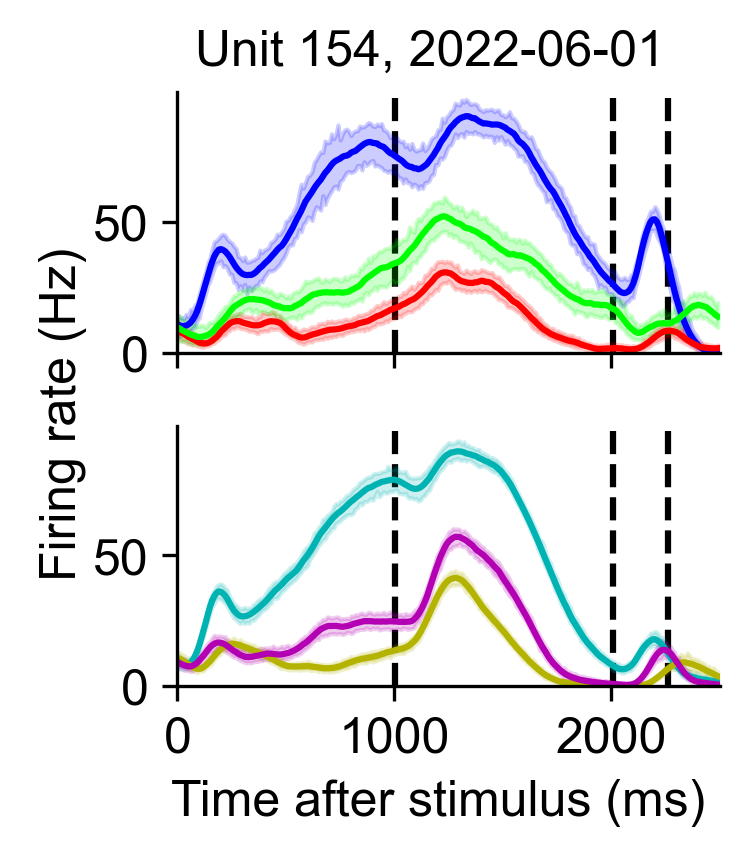

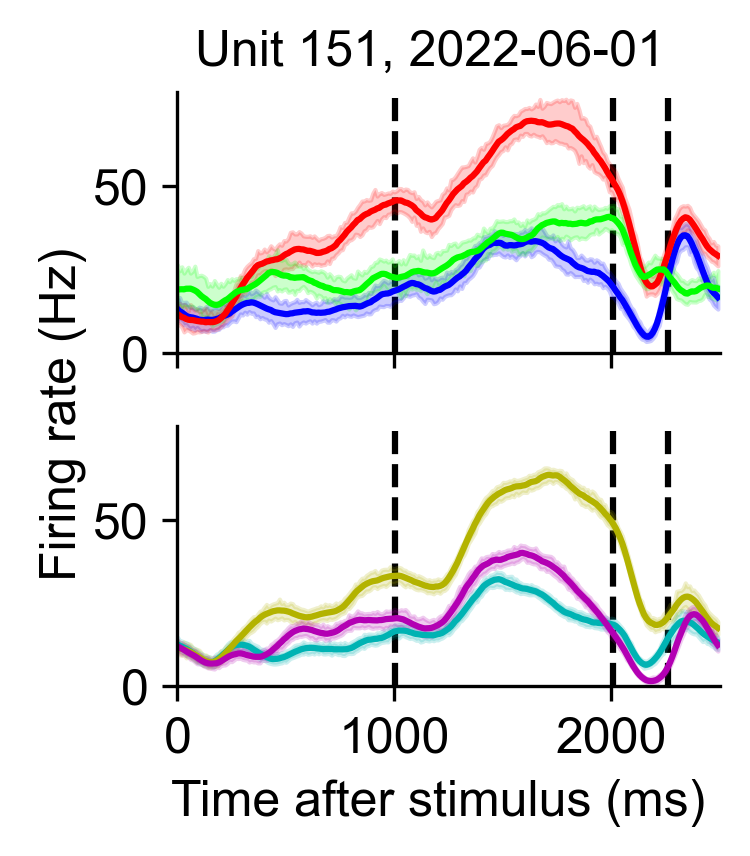

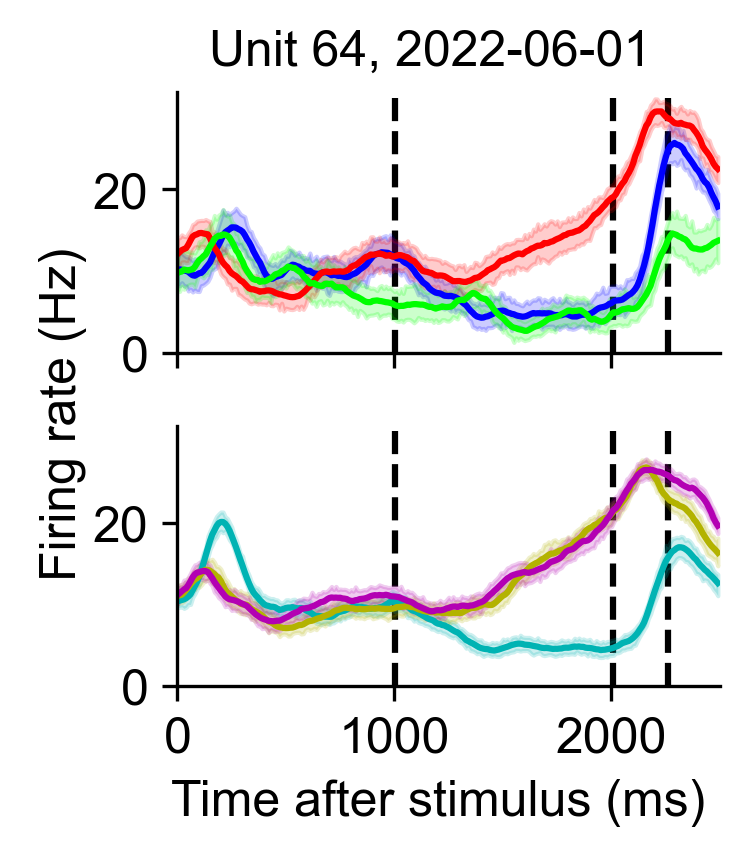

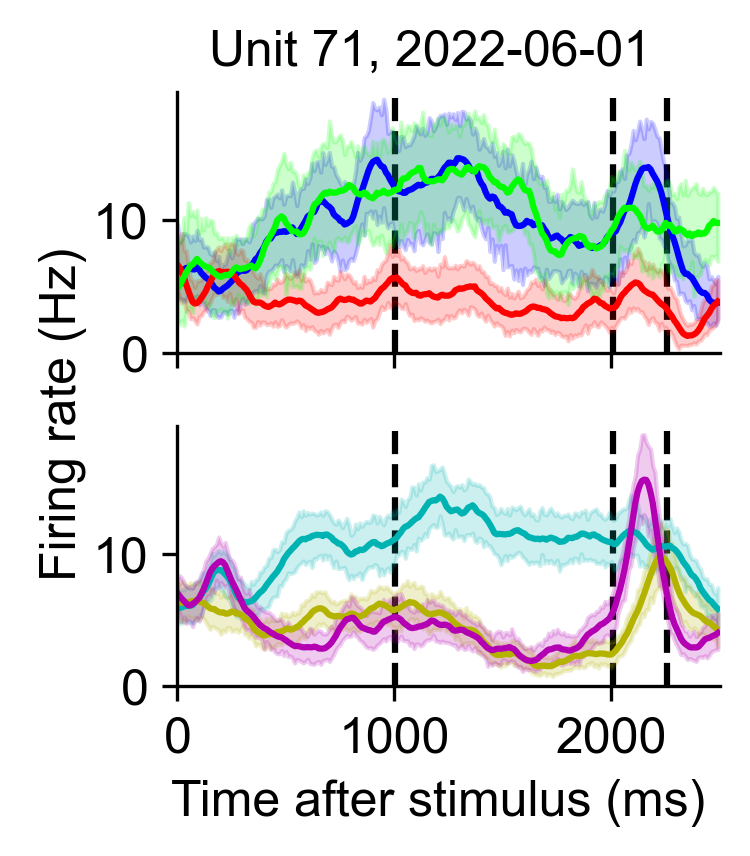

In [4]:
subject = 'Perle'
session = '2022-06-01'
quality = 'good'

probe_unit = [
    ('s0', 154),
    ('s0', 151),
    ('vprobe1', 64),
    ('vprobe1', 71),
]
for probe, unit in probe_unit:
    fig = generate_psth(
        subject=subject,
        session=session,
        probe=probe,
        quality=quality,
        unit=unit,
    )
    fig.savefig(WRITE_DIR / f"{subject}_{session}_{probe}_{quality}_{unit}.pdf", bbox_inches='tight', pad_inches=0.01)